In [1]:
import numpy as np
import matplotlib.pylab as plt
import copy
import sys
sys.path.append('../')

from angler import Simulation, Optimization
from angler.structures import three_port, two_port

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
lambda0 = 2e-6              # free space wavelength (m)
c0 = 3e8                    # speed of light in vacuum (m/s)
omega = 2*np.pi*c0/lambda0  # angular frequency (2pi/s)
dl = 1e-1                 # grid size (L0)
NPML = [20, 20]             # number of pml grid points on x and y borders
pol = 'Ez'                  # polarization (either 'Hz' or 'Ez')
source_amp = 4              # amplitude of modal source (A/L0^2?)

In [3]:
# material constants
n_index = 2.44              # refractive index
eps_m = n_index**2          # relative permittivity
chi3 = 4.1*1e-19            # Al2S3 from Boyd (m^2/V^2)
# max_ind_shift = 5.8e-3      # maximum allowed nonlinear refractive index shift (computed from damage threshold)

In [4]:
# geometric parameters
L = 6         # length of box (L0)
H = 6         # height of box (L0)
w = .3        # width of waveguides (L0)
d = H/1.5    # distance between waveguides (L0)
l = 5         # length of waveguide from PML to box (L0)
spc = 3       # space between box and PML (L0)

Computed a domain with 200 grids in x and 160 grids in y
The simulation has 20 grids per free space wavelength


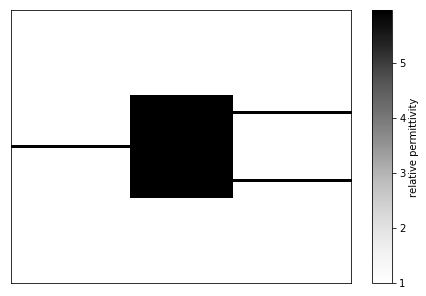

In [5]:
# define permittivity of three port system
eps_r, design_region = three_port(L, H, w, d, l, spc, dl, NPML, eps_m)
(Nx, Ny) = eps_r.shape
nx, ny = int(Nx/2), int(Ny/2)            # halfway grid points

simulation = Simulation(omega,eps_r,dl,NPML,pol)
# compute the grid size the total grid size
print("Computed a domain with {} grids in x and {} grids in y".format(Nx,Ny))
print("The simulation has {} grids per free space wavelength".format(int(lambda0/dl/simulation.L0)))
simulation.plt_eps(outline=False)
plt.show()

In [6]:
# set the modal source and probes
simulation = Simulation(omega, eps_r, dl, NPML, 'Ez')
simulation.add_mode(np.sqrt(eps_m), 'x', [NPML[0]+int(l/2/dl), ny], int(H/2/dl), scale=source_amp)
simulation.setup_modes()

# top modal profile
top = Simulation(omega, eps_r, dl, NPML, 'Ez')
top.add_mode(np.sqrt(eps_m), 'x', [-NPML[0]-int(l/2/dl), ny+int(d/2/dl)], int(H/2/dl))
top.setup_modes()
J_top = np.abs(top.src)

# bottom modal profile
bot = Simulation(omega, eps_r, dl, NPML, 'Ez')
bot.add_mode(np.sqrt(eps_m), 'x', [-NPML[0]-int(l/2/dl), ny-int(d/2/dl)], int(H/2/dl))
bot.setup_modes()
J_bot = np.abs(bot.src)

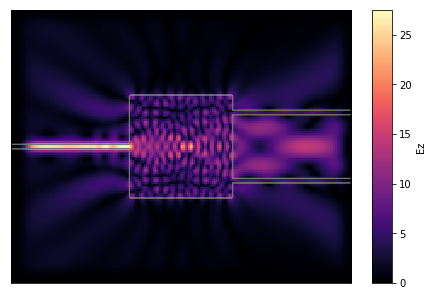

In [7]:
# set source and solve for electromagnetic fields
(_, _, Ez) = simulation.solve_fields()
simulation.plt_abs(outline=True, cbar=True);

In [8]:
# compute straight line simulation
eps_r_wg, _ = two_port(L, H, w, l, spc, dl, NPML, eps_start=eps_m)
(Nx_wg, Ny_wg) = eps_r_wg.shape
nx_wg, ny_wg = int(Nx_wg/2), int(Ny_wg/2)            # halfway grid points     
simulation_wg = Simulation(omega, eps_r_wg, dl, NPML, 'Ez')
simulation_wg.add_mode(np.sqrt(eps_m), 'x', [NPML[0]+int(l/2/dl), ny_wg], int(Ny/3), scale=source_amp)
simulation_wg.setup_modes()

# compute normalization
sim_out = Simulation(omega, eps_r_wg, dl, NPML, 'Ez')
sim_out.add_mode(np.sqrt(eps_m), 'x', [-NPML[0]-int(l/2/dl), ny], int(Ny/3))
sim_out.setup_modes()
J_out = np.abs(sim_out.src)
(_, _, Ez_wg) = simulation_wg.solve_fields()
SCALE = np.sum(np.square(np.abs(Ez_wg))*J_out)
J_out = J_out
print('computed a scale of {} in units of E^2 J_out'.format(SCALE))

J_top = J_top / SCALE
J_bot = J_bot / SCALE

computed a scale of 953.5595637542789 in units of E^2 J_out


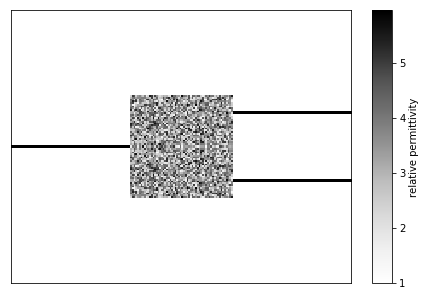

In [9]:
# changes design region. 'style' can be in {'full', 'empty', 'halfway', 'random'}
simulation.init_design_region(design_region, eps_m, style='random_sym')
simulation.plt_eps(outline=False)
plt.show()

In [10]:
# add nonlinearity
nl_region = copy.deepcopy(design_region)

simulation.nonlinearity = []  # This is needed in case you re-run this cell, for example (or you can re-initialize simulation every time)
simulation.add_nl(chi3, nl_region, eps_scale=True, eps_max=eps_m)

In [11]:
# define objective function
import autograd.numpy as npa
from angler.objective import Objective, obj_arg
arg1 = obj_arg('ez', component='Ez', nl=False)
arg2 = obj_arg('ez_nl', component='Ez', nl=True)

def J(e, e_nl):
    linear_top =     1*npa.sum(npa.square(npa.abs(e))*J_top)
    linear_bot =     1*npa.sum(npa.square(npa.abs(e))*J_bot)
    nonlinear_top =  1*npa.sum(npa.square(npa.abs(e_nl))*J_top)
    nonlinear_bot =  1*npa.sum(npa.square(npa.abs(e_nl))*J_bot)
    objfn = ( (linear_top - nonlinear_top) + (nonlinear_bot - linear_bot) ) / 2
    return objfn

objective = Objective(J, arg_list=[arg1, arg2])

In [12]:
# make optimization object and check derivatives
R = 4     # filter radius of curvature (pixels)  (takes a while to set up as R > 5-10)
beta = 300
eta= 0.50
simulation.init_design_region(design_region, eps_m, style='random_sym')
optimization = Optimization(objective=objective, simulation=simulation, design_region=design_region, eps_m=eps_m, R=R, beta=beta, eta=eta)

 98% (148 of 151) |##################### | Elapsed Time: 0:00:13 ETA:   0:00:00

In [13]:
# check the derivatives (note, full derivatives are checked, linear and nonlinear no longer separate)
(grad_avm, grad_num) = optimization.check_deriv(Npts=5, d_rho=5e-4)
print('adjoint gradient   = {}\nnumerical gradient = {}'.format(grad_avm, grad_num))

adjoint gradient   = [-1.4172243546989663e-06, 1.0098186084706723e-06, -5.466654177390621e-07, 7.349246193494384e-08, -1.4779513992735447e-07]
numerical gradient = [-1.0413041505452636e-06, 5.756601688389207e-07, -3.787595723170334e-07, -7.142024124884294e-08, 1.161350744738332e-06]


In [14]:
# optimization.beta = 200
# optimization.eta = 0.5
new_eps = optimization.run(method='lbfgs', Nsteps=1000, step_size=1e-2)

 ObjectiveFn: 8.19e-06 Iteration:  6/1000 ETA:   9:10:32                       

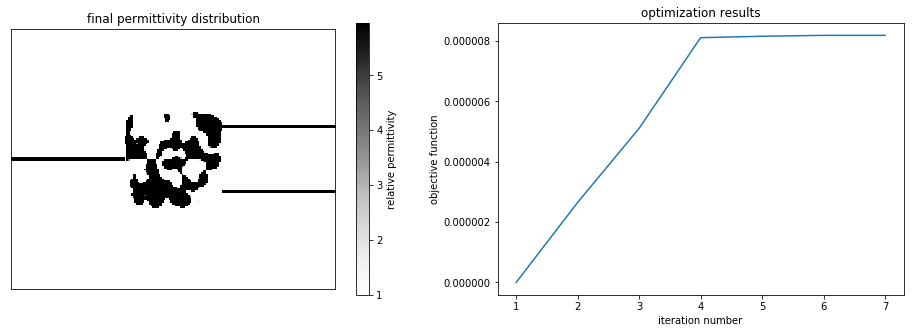

In [15]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
simulation.plt_eps(ax=ax1, outline=False)
ax1.set_title('final permittivity distribution')
optimization.plt_objs(ax=ax2)
ax2.set_yscale('linear')
plt.show()

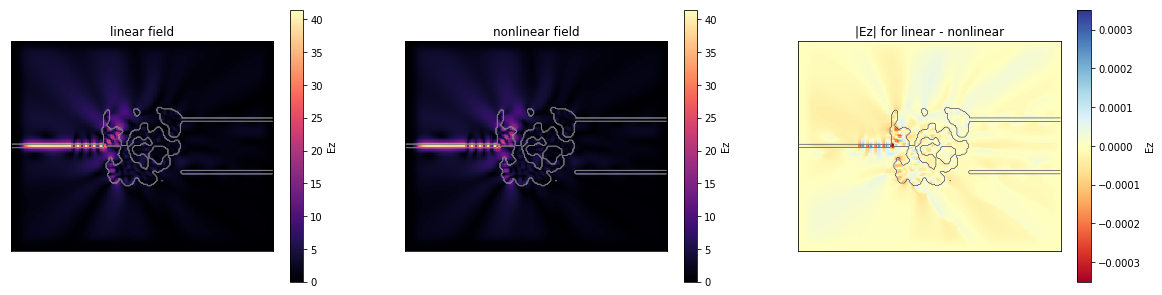

In [16]:
# compare the linear and nonlinear fields

# setup subplots
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,5))

# linear fields
(Hx,Hy,Ez) = simulation.solve_fields()
simulation.plt_abs(ax=ax1, vmax=None)
ax1.set_title('linear field')

# nonlinear fields
(Hx_nl,Hy_nl,Ez_nl,_) = simulation.solve_fields_nl()
simulation.plt_abs(ax=ax2, vmax=None, nl=True)
ax2.set_title('nonlinear field')

# difference
simulation.plt_diff(ax=ax3)
ax3.set_title('|Ez| for linear - nonlinear')

plt.show()

maximum refractive index shift of 0.00022174465111746144


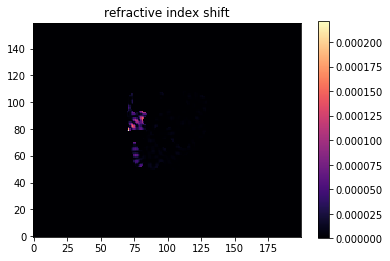

In [17]:
# compute the refractive index shift
index_shift = simulation.compute_index_shift()
print('maximum refractive index shift of {}'.format(np.max(index_shift)))
plt.imshow(index_shift.T, cmap='magma', origin='lower')
plt.colorbar()
plt.title('refractive index shift')
plt.show()

        -> W_in = 0.41821011498772054
        -> linear transmission (top)        = 0.0139
        -> linear transmission (bottom)     = 0.0259
        -> nonlinear transmission (top)     = 0.0139
        -> nonlinear transmission (bottom)  = 0.0259


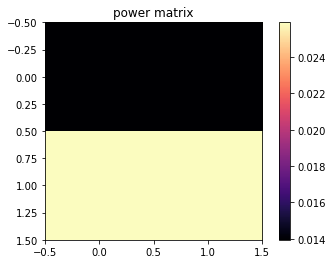

In [18]:
W_in = simulation.W_in
print("        -> W_in = {}".format(W_in))

# linear powers
W_top_lin = simulation.flux_probe('x', [-NPML[0]-int(l/2/dl), ny+int(d/2/dl)], int(H/2/dl))
W_bot_lin = simulation.flux_probe('x', [-NPML[0]-int(l/2/dl), ny-int(d/2/dl)], int(H/2/dl))

# nonlinear powers
W_top_nl = simulation.flux_probe('x', [-NPML[0]-int(l/2/dl), ny+int(d/2/dl)], int(H/2/dl), nl=True)
W_bot_nl = simulation.flux_probe('x', [-NPML[0]-int(l/2/dl), ny-int(d/2/dl)], int(H/2/dl), nl=True)


print('        -> linear transmission (top)        = {:.4f}'.format(W_top_lin / W_in))
print('        -> linear transmission (bottom)     = {:.4f}'.format(W_bot_lin / W_in))
print('        -> nonlinear transmission (top)     = {:.4f}'.format(W_top_nl / W_in))
print('        -> nonlinear transmission (bottom)  = {:.4f}'.format(W_bot_nl / W_in))

S = [[W_top_lin / W_in, W_top_nl / W_in],
          [W_bot_lin / W_in, W_bot_nl / W_in]]

plt.imshow(S, cmap='magma')
plt.colorbar()
plt.title('power matrix')
plt.show()